<a href="https://colab.research.google.com/github/Cheese-5040/OCT-Scan-Segmentation/blob/main/better_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange #basically pakage that show progress bar in loops
from itertools import chain #function used to create efficient looping in python

#package used for image processing
from skimage.io import imread, imshow, concatenate_images
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf

from keras.models import Model, load_model
#input is used to instantiate a keras tensor
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D, Concatenate#batchnormalization -> transformation that maintain mean close to 0 and SD close to 1
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau #save weights at some freq, reduce learning rate when metric stop improving
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import normalize, to_categorical

# import matplotlib.image as mpimg
import cv2 
# from google.colab.patches import cv2_imshow

#dock to drive + set params for width and height 

In [ ]:
# Check is Link to Drive is OK, then dock to drive
google = !if [ -d 'GDrive/' ]; then echo "1" ; else echo "0"; fi
if (google[0] is '0' ):
  from google.colab import drive
  drive.mount('/content/GDrive/')
!if [ -d 'GDrive/' ]; then echo "Connection to Google drive successful" ; else echo "Error to connect to Google drive"; fi


Connection to Google drive successful


In [ ]:
im_width = 128
im_height = 128
border =5
n_classes = 6

#getting image and mask data

In [ ]:
#getting all image and mask, and saving to X and y respectively
# tqdm is used to display the progress bar

def get_image_mask(all_patients):
    train_images = []
    train_masks = []
    index = 0
    for N, patient in tqdm_notebook(enumerate(all_patients), total= len(all_patients)):
        PATIENT_PATH = "/content/GDrive/My Drive/OCT2/"+str(patient)
        pic_ids = os.listdir(PATIENT_PATH+"/raw/labeled") # list of names all images in the given path
        print(f"No. of images for patient {patient} = {len(pic_ids)}")
        for id_ in pic_ids:
            # Load images in google drive
            img = imread(PATIENT_PATH+"/raw/labeled/"+id_, as_gray = True)
            img = cv2.resize(img, (im_height, im_width))
            train_images.append(img)
            # Load masks
            mask = imread(PATIENT_PATH+"/mask/number/"+id_, as_gray = True)
            mask = cv2.resize(mask,(im_height, im_width))
            train_masks.append(mask)
            index +=1
    print("total images is : ", index)
    return train_images, train_masks

#counting the total number of pics in the dataset
ALL_PATIENT = "GDrive/My Drive/OCT2/"
patients = os.listdir(ALL_PATIENT) # list of names all images in the given path

#remove patient 23 since there is no labelled pics
patients.remove('patient23')
print(patients)
# patients = ['patient1']

T_image, T_mask = get_image_mask(patients)
T_image = np.array(T_image)
T_mask = np.array(T_mask)

['patient4', 'patient24', 'patient9', 'patient3', 'patient5', 'patient6', 'patient8', 'patient22', 'patient7', 'patient16', 'patient15', 'patient18', 'patient14', 'patient20', 'patient19', 'patient2', 'patient21', 'patient13', 'patient17', 'patient12', 'patient11', 'patient10', 'patient1']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/23 [00:00<?, ?it/s]

No. of images for patient patient4 = 56
No. of images for patient patient24 = 33
No. of images for patient patient9 = 73
No. of images for patient patient3 = 20
No. of images for patient patient5 = 49
No. of images for patient patient6 = 36
No. of images for patient patient8 = 71
No. of images for patient patient22 = 31
No. of images for patient patient7 = 103
No. of images for patient patient16 = 49
No. of images for patient patient15 = 97
No. of images for patient patient18 = 61
No. of images for patient patient14 = 31
No. of images for patient patient20 = 66
No. of images for patient patient19 = 21
No. of images for patient patient2 = 68
No. of images for patient patient21 = 21
No. of images for patient patient13 = 30
No. of images for patient patient17 = 21
No. of images for patient patient12 = 19
No. of images for patient patient11 = 21
No. of images for patient patient10 = 87
No. of images for patient patient1 = 41
total images is :  1105


In [ ]:
#clean up T_mask abit
#since class7 & 8 is very very rare, we will group them together
print(T_mask.ndim)
for i in range(len(T_mask)):
    for j in range(im_width):
      for k in range(im_height):
        T_mask[i][j][k] = 5 if T_mask[i][j][k]>5 else T_mask[i][j][k]
np.unique(T_mask[0])

3


array([0, 1, 2, 3, 4, 5], dtype=uint8)

shape of images (128, 128)
num images : 1105
shape of mask (128, 128)
num mask : 1105
num_classes : [0 1 2 3 4 5]


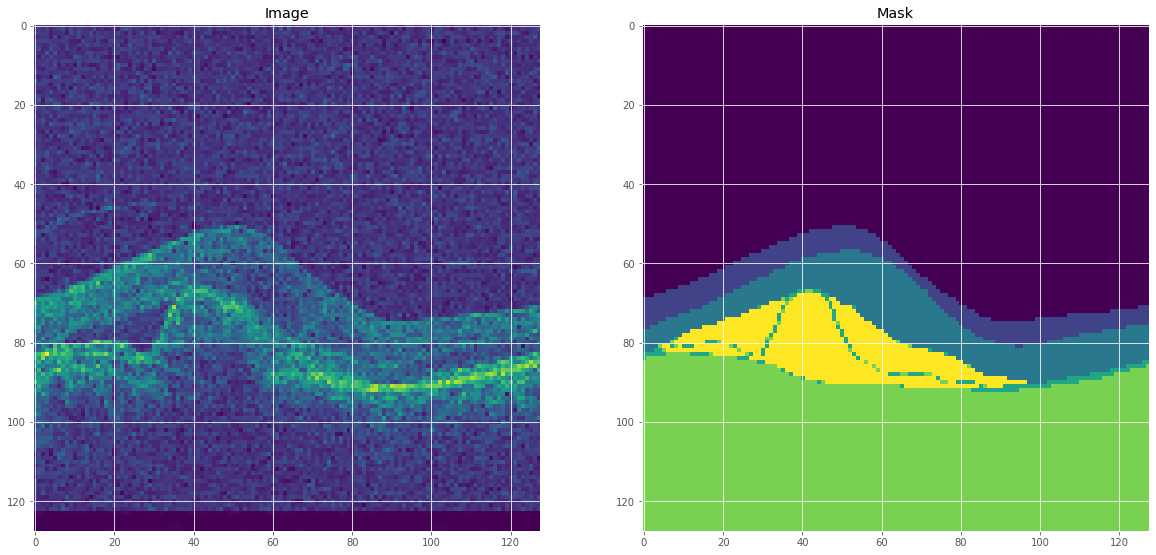

In [ ]:
import random
#print random mask 
def show_img_and_mask(img, mask):
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,15))
    ax1.set_title("Image")
    ax1.imshow(img)
    ax2.set_title("Mask")
    ax2.imshow(mask)

def print_mask(mask):
  with np.printoptions(threshold=np.inf):
      print(mask)

def shape_info(images, masks):
    print(f"shape of images {images[0].shape}")
    print(f"num images : {len(images)}")
    print(f"shape of mask {masks[0].shape}")
    print(f"num mask : {len(masks)}")
    print(f"num_classes : {np.unique(masks)}")

shape_info(T_image, T_mask)

rand_num = random.randint(0, len(T_image))
show_img_and_mask(T_image[rand_num], T_mask[rand_num])


# ensuring that mask is encoded properly


In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

'''
optional step: just ensuring that the classes are 0-5 consecutively and no number skipped
'''

#get the shape of train_masks, number, height, width
n, h, w = T_mask.shape
#reshape train mask to one single vector (n*im_height * im_width, 1)
T_masks_reshaped = T_mask.reshape(-1,1)
#encode target label values from 0 to n_classes-1
T_masks_reshaped_encoded = labelencoder.fit_transform(T_masks_reshaped)
#change back the shape to ensure no operlap between classes / skip number
T_masks_encoded_original_shape = T_masks_reshaped_encoded.reshape(n, h, w)
print(T_masks_reshaped.shape)
print(T_masks_encoded_original_shape.shape)
print(np.unique(T_masks_encoded_original_shape))


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(18104320, 1)
(1105, 128, 128)
[0 1 2 3 4 5]


#normalizing data + processing + reshaping


In [ ]:
train_images = np.expand_dims(T_image, axis = 3)
train_images = normalize(train_images, axis = 1)
train_masks_input = np.expand_dims(T_masks_encoded_original_shape, axis=3)

print(f"shape of train_images : {train_images.shape}")
print(f"shape of train_masks_input : {train_masks_input.shape}")

shape of train_images : (1105, 128, 128, 1)
shape of train_masks_input : (1105, 128, 128, 1)


In [ ]:
'''double split to train'''
#10% testing, 90% training 
X1, X_test, y1, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)
print(f"shape of X1 : {X1.shape}")
print(f"shape of X_test : {X_test.shape}")
print(f"shape of y1 : {y1.shape}")
print(f"shape of y_test : {y_test.shape}")
#Further split training data t a smaller subset for quick testing of models (20% test, 90% train)
X_train, X_do_not_use, y_train, y_do_not_use = train_test_split(X1, y1, test_size = 0.2, random_state = 0)
print(f"classes num in dataset are: {np.unique(y_train)}")
print(f"shape of X_train : {X_train.shape}")
print(f"shape of X_do_not_use : {X_do_not_use.shape}")
print(f"shape of y_train : {y_train.shape}")
print(f"shape of y_do_not_use : {y_do_not_use.shape}")


shape of X1 : (994, 128, 128, 1)
shape of X_test : (111, 128, 128, 1)
shape of y1 : (994, 128, 128, 1)
shape of y_test : (111, 128, 128, 1)
classes num in dataset are: [0 1 2 3 4 5]
shape of X_train : (795, 128, 128, 1)
shape of X_do_not_use : (199, 128, 128, 1)
shape of y_train : (795, 128, 128, 1)
shape of y_do_not_use : (199, 128, 128, 1)


In [ ]:
'''
convert to categories instead of classes, then add at the end of shape
eg: first class? 1 - 0
    second class ? 1 - 0
'''
print("format is (num images, heigth, width, number of classes)")
print(f"shape of old y_train : {y_train.shape}")
train_masks_category = to_categorical(y_train, num_classes = n_classes)
y_train_category = train_masks_category.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))
# print(f"shape of train_masks_category : {train_masks_category.shape}")
print(f"shape of y_train after categorization : {y_train_category.shape}")

print(f"\nshape of old y_test : {y_test.shape}")
test_masks_category = to_categorical(y_test, num_classes = n_classes)
y_test_category = test_masks_category.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))
# print(f"shape of test_masks_category : {test_masks_category.shape}")
print(f"shape of y_test after categorization : {y_test_category.shape}")

format is (num images, heigth, width, number of classes)
shape of old y_train : (795, 128, 128, 1)
shape of y_train after categorization : (795, 128, 128, 6)

shape of old y_test : (111, 128, 128, 1)
shape of y_test after categorization : (111, 128, 128, 6)


# adjusting weights 

since there are alot of 0s, 7s and 8s in the mask at the top and bottom labelled part compared to any other number, we need to readjust the weights according to their numbers. As a result, they are assigned a weight that is significantly smaller than other classes to balance it.

In [ ]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(T_masks_reshaped_encoded),
                                                 T_masks_reshaped_encoded)
class_weights = {i : class_weights[i] for i in range(n_classes)}
print("Class weights after balancing are:", class_weights)


Class weights after balancing are: {0: 0.4724310904474003, 1: 3.2756272957844232, 2: 2.125746534333534, 3: 16.47791666894208, 4: 0.3453775718623134, 5: 6.6001414499347435}


In [ ]:
IMG_HEIGHT = X_train.shape[1] #128
IMG_WIDTH  = X_train.shape[2] #128
IMG_CHANNELS = X_train.shape[3] #1

# UNET architecture

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda


def multi_unet_model(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [ ]:
from IPython.display import Javascript
display(Javascript("google.colab.output.resizeIframeToContent()"))


<IPython.core.display.Javascript object>

In [ ]:
model = multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
#not sigmoid since it is multiclass, so categorical crossentropy is used, can use focal_loss also for unbalanced 
#metrics can use accuracy or dice coefficient
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d_57 (Conv2D)              (None, 128, 128, 16) 160         input_4[0][0]                    
__________________________________________________________________________________________________
dropout_27 (Dropout)            (None, 128, 128, 16) 0           conv2d_57[0][0]                  
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 128, 128, 16) 2320        dropout_27[0][0]                 
____________________________________________________________________________________________

In [ ]:
callbacks = [
    EarlyStopping(patience=10, verbose=1), #stop training when metric has stopped improving, patience = num epoch with no improvement, verbose shows the training progress, 0 show nothing, 1 show progress bar, 2 show numbet
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1), #reduce learning rate when metric stopped improving, factor is factor of reduction for LR, patience is num epoch w no improvement, verbose = update message
    ModelCheckpoint('model-oct', verbose=1, save_best_only=True, save_weights_only=True)#save model or weights at some interval so can be loaded later to continue learning rate, first arg is file path
]
print(f"shape of X_test : {X_test.shape}")
print(f"shape of y_test after categorization : {y_test_category.shape}")
history = model.fit(X_train, y_train_category, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_test, y_test_category))#, 
                    # class_weight=class_weights)

shape of X_test : (111, 128, 128, 1)
shape of y_test after categorization : (111, 128, 128, 6)
Epoch 1/50
50/50 [==============================] - 128s 3s/step - loss: 0.0372 - accuracy: 0.9864 - val_loss: 0.0307 - val_accuracy: 0.9884
Epoch 2/50
50/50 [==============================] - 126s 3s/step - loss: 0.0302 - accuracy: 0.9885 - val_loss: 0.0293 - val_accuracy: 0.9888
Epoch 3/50
50/50 [==============================] - 127s 3s/step - loss: 0.0290 - accuracy: 0.9890 - val_loss: 0.0298 - val_accuracy: 0.9886
Epoch 4/50
50/50 [==============================] - 127s 3s/step - loss: 0.0287 - accuracy: 0.9890 - val_loss: 0.0287 - val_accuracy: 0.9890
Epoch 5/50
50/50 [==============================] - 127s 3s/step - loss: 0.0281 - accuracy: 0.9892 - val_loss: 0.0307 - val_accuracy: 0.9883
Epoch 6/50
50/50 [==============================] - 126s 3s/step - loss: 0.0284 - accuracy: 0.9891 - val_loss: 0.0300 - val_accuracy: 0.9885
Epoch 7/50
50/50 [==============================] - 126s 3s

In [ ]:
#save model
model_save_name = 'oct_UNET3'
model.save(f"/content/GDrive/My Drive/{model_save_name}" )

INFO:tensorflow:Assets written to: /content/GDrive/My Drive/oct_UNET3/assets


In [ ]:
# evaluate model
_, acc = model.evaluate(X_test, y_test_category)
print("Accuracy is = ", (acc * 100.0), "%")


###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
from tensorflow import keras
model_save_name = 'oct_UNET2'
model = tf.keras.models.load_model(f"/content/GDrive/My Drive/{model_save_name}")

#dice coeff


In [ ]:
y_pred=model.predict(X_test) #use current model to predict and segment X_test data
# prediction is in probabilities, and argmax find argument that give max value, find class with max probability
y_pred_argmax=np.argmax(y_pred, axis=3)


In [ ]:
from keras import backend as K
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
        print(f"dice coeff of {index+1} class is : {dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])}")
    return dice/numLabels # taking average

# dice = dice_coef(y_test_category.astype('float32'), y_pred.astype('float32'))
dice = dice_coef_multilabel(y_test_category.astype('float32'), y_pred.astype('float32'), n_classes)
dice = np.array(dice)
print(f"dice coefficient is : {np.mean(dice)}")

dice coeff of 1 class is : 0.9976885285646616
dice coeff of 2 class is : 0.9515846240032118
dice coeff of 3 class is : 0.9561421358203702
dice coeff of 4 class is : 0.6319672009638628
dice coeff of 5 class is : 0.9950748091428457
dice coeff of 6 class is : 0.8695533358883243
dice coefficient is : 0.9003351057305461


#calculating intersection over union (IOU)

In [ ]:
from keras.metrics import MeanIoU
n_classes = 6
IOU_keras = MeanIoU(num_classes = n_classes)
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
'''
IOU means the overlap of predicted segment and ground truth over total area
'''
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.87770176


[[6.38516e+05 1.05200e+03 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00]
 [8.05000e+02 8.76940e+04 1.78000e+03 0.00000e+00 2.00000e+01 5.50000e+01]
 [1.00000e+00 2.19500e+03 1.40753e+05 9.25000e+02 0.00000e+00 8.68000e+02]
 [0.00000e+00 1.30000e+01 1.79100e+03 1.25720e+04 1.70500e+03 2.57000e+03]
 [5.00000e+00 3.20000e+01 2.55000e+02 1.26700e+03 8.78890e+05 1.88300e+03]
 [1.50000e+01 8.50000e+01 1.46400e+03 9.98000e+02 4.68000e+02 3.99470e+04]]
IoU for class1 is:  0.99706745
IoU for class2 is:  0.9355923
IoU for class3 is:  0.9381532
IoU for class4 is:  0.5756147
IoU for class5 is:  0.99362934
IoU for class6 is:  0.8261535
mean IoU is :  0.8777017593383789


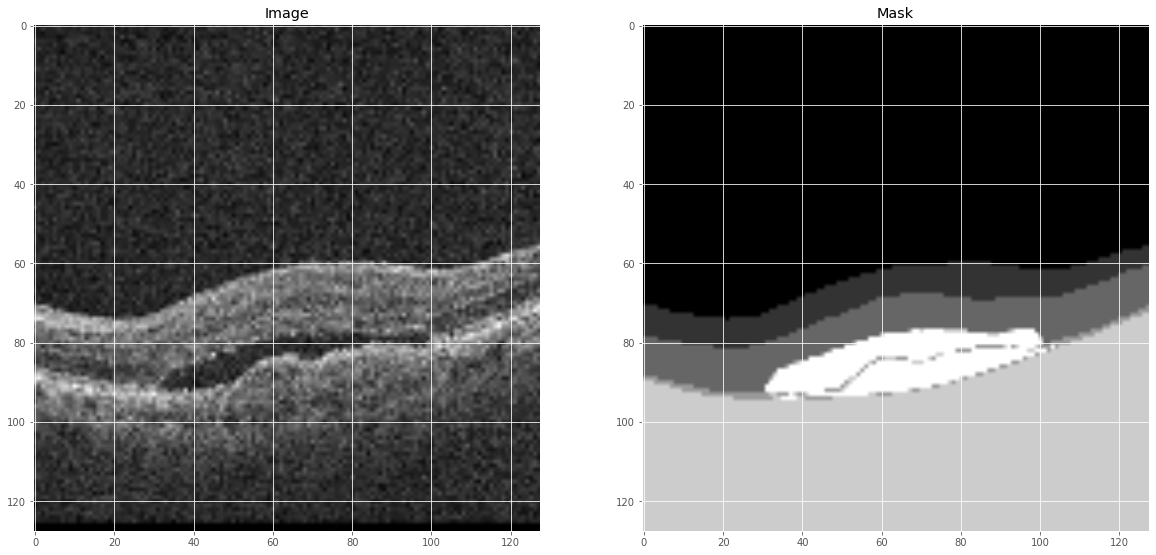

In [ ]:
values = np.array(IOU_keras.get_weights()).reshape(n_classes, n_classes)
# print(values)
class1_IoU = values[0,0]/(values[0,0] + values[0,1] + values[0,2] + values[0,3] + values[0,4] + values[0,5] + values[1,0] + values[2,0] + values[3,0] + values[4,0] + values[5,0])
class2_IoU = values[1,1]/(values[1,1] + values[1,0] + values[1,2] + values[1,3] + values[1,4] + values[1,5] + values[0,1] + values[2,1] + values[3,1] + values[4,1] + values[5,1])
class3_IoU = values[2,2]/(values[2,2] + values[2,0] + values[2,1] + values[2,3] + values[2,4] + values[2,5] + values[0,2] + values[1,2] + values[3,2] + values[4,2] + values[5,2])
class4_IoU = values[3,3]/(values[3,3] + values[3,0] + values[3,1] + values[3,2] + values[3,4] + values[3,5] + values[0,3] + values[1,3] + values[2,3] + values[4,3] + values[5,3])
class5_IoU = values[4,4]/(values[4,4] + values[4,0] + values[4,1] + values[4,2] + values[4,3] + values[4,5] + values[0,4] + values[1,4] + values[2,4] + values[3,4] + values[5,4])
class6_IoU = values[5,5]/(values[5,5] + values[5,0] + values[5,1] + values[5,2] + values[5,3] + values[5,4] + values[0,5] + values[1,5] + values[2,5] + values[3,5] + values[4,5])


print("IoU for class1 is: ", class1_IoU)
print("IoU for class2 is: ", class2_IoU)
print("IoU for class3 is: ", class3_IoU)
print("IoU for class4 is: ", class4_IoU)
print("IoU for class5 is: ", class5_IoU)
print("IoU for class6 is: ", class6_IoU)
print("mean IoU is : ", (class1_IoU + class2_IoU + class3_IoU + class4_IoU + class5_IoU + class6_IoU)/6)


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,15))
ax1.set_title("Image")
ax1.imshow(train_images[100,:,:,0], cmap='gray', interpolation = 'bilinear')
ax2.set_title("Mask")  
ax2.imshow(T_mask[100], cmap='gray',interpolation = 'bilinear')

#load random images and predict segments

In [ ]:
import random
def random_pic():
    test_img_number = random.randint(0, len(y_test_category))
    test_img = X_test[test_img_number]
    ground_truth=y_test[test_img_number]
    test_img_norm=test_img[:,:,0][:,:,None]
    test_img_input=np.expand_dims(test_img_norm, 0)
    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]


    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_img[:,:,0], cmap='gray')
    plt.subplot(232)
    plt.title('Testing Label')
    plt.imshow(ground_truth[:,:,0], cmap='jet')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(predicted_img, cmap='jet')
    plt.show()


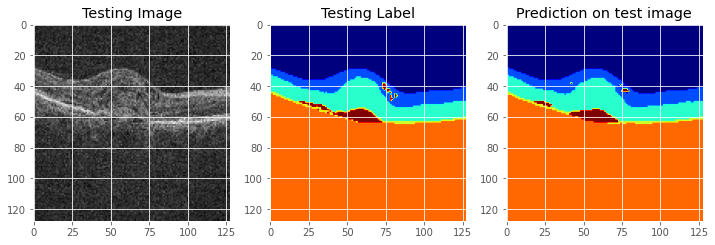

In [ ]:
random_pic()

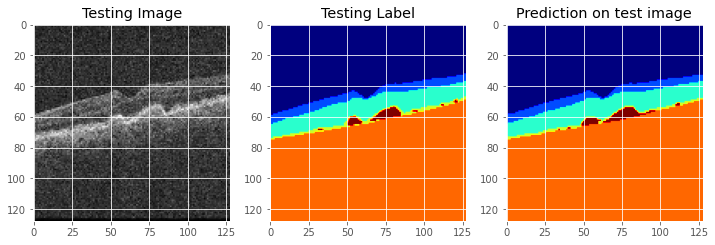

In [ ]:
random_pic()

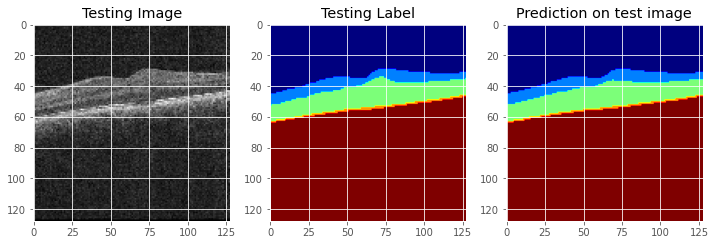

In [ ]:
random_pic()

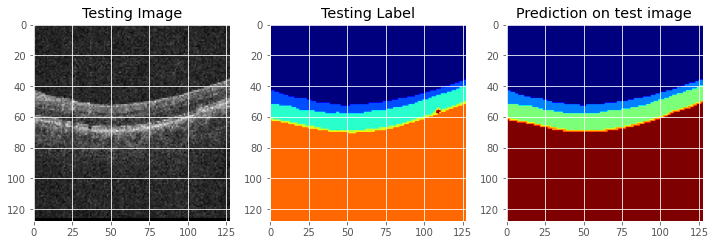

In [ ]:
random_pic()